# Assignment 1 - Part 2: Overfitting Analysis
## Overfitting (8 points)

This notebook simulates a data generating process and analyzes overfitting by estimating linear models with increasing numbers of polynomial features.

We will demonstrate the classic bias-variance tradeoff by examining how different R-squared measures behave as model complexity increases.

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Data Generation

We'll generate data following a simple relationship: y = 2X + u, where u is random noise. This gives us a known ground truth to compare against.

In [ ]:
def generate_data(n=1000, seed=42):
    """
    Generate data following the specification with only 2 variables X and Y.
    Intercept parameter is set to zero as requested.
    
    Parameters:
    -----------
    n : int
        Sample size (default: 1000)
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : numpy.ndarray
        Feature matrix
    
    """
    np.random.seed(seed)
    
    # Generate X (single feature initially)
    X = np.random.randn(n, 1)
    
    # Generate error term
    u = np.random.randn(n)
    
    # Generate y with no intercept (as requested)
    # True relationship: y = 2*X + u
    beta_true = 2.0
    y = beta_true * X.ravel() + u
    
    return X, y

# Generate the data
X, y = generate_data(n=1000, seed=42)

print(f"Generated data with n={len(y)} observations")
print(f"True relationship: y = 2*X + u")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X mean: {X.mean():.4f}, X std: {X.std():.4f}")
print(f"y mean: {y.mean():.4f}, y std: {y.std():.4f}")

Generated data with n=1000 observations
True relationship: y = 2*X + u
X shape: (1000, 1)
y shape: (1000,)
X mean: 0.0193, X std: 0.9787
y mean: 0.1095, y std: 2.1605


## Polynomial Feature Creation

We'll create polynomial features of increasing complexity to study overfitting behavior.

In [3]:
def create_polynomial_features(X, n_features):
    """
    Create polynomial features up to n_features.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Original feature matrix (n x 1)
    n_features : int
        Number of features to create
        
    Returns:
    --------
    X_poly : numpy.ndarray
        Extended feature matrix with polynomial features
    """
    n_samples = X.shape[0]
    X_poly = np.zeros((n_samples, n_features))
    
    for i in range(n_features):
        if i == 0:
            X_poly[:, i] = X.ravel()  # x^1
        else:
            X_poly[:, i] = X.ravel() ** (i + 1)  # x^2, x^3, etc.
    
    return X_poly

# Example: create polynomial features
X_poly_example = create_polynomial_features(X, 5)
print(f"Example: Original X shape: {X.shape}")
print(f"Example: Polynomial features (5 features) shape: {X_poly_example.shape}")
print(f"First 5 rows of polynomial features:")
print(X_poly_example[:5, :])

Example: Original X shape: (1000, 1)
Example: Polynomial features (5 features) shape: (1000, 5)
First 5 rows of polynomial features:
[[ 4.96714153e-01  2.46724950e-01  1.22551774e-01  6.08732009e-02
   3.02365804e-02]
 [-1.38264301e-01  1.91170170e-02 -2.64320099e-03  3.65460338e-04
  -5.05301183e-05]
 [ 6.47688538e-01  4.19500442e-01  2.71705628e-01  1.75980621e-01
   1.13980631e-01]
 [ 1.52302986e+00  2.31961994e+00  3.53285043e+00  5.38063668e+00
   8.19487031e+00]
 [-2.34153375e-01  5.48278029e-02 -1.28381151e-02  3.00608797e-03
  -7.03885643e-04]]


## Adjusted R-squared Calculation

We'll implement adjusted R-squared, which penalizes model complexity.

In [4]:
def calculate_adjusted_r2(r2, n, k):
    """
    Calculate adjusted R-squared.
    
    Adjusted R² = 1 - [(1 - R²)(n - 1) / (n - k - 1)]
    
    Parameters:
    -----------
    r2 : float
        R-squared value
    n : int
        Sample size
    k : int
        Number of features (excluding intercept)
        
    Returns:
    --------
    adj_r2 : float
        Adjusted R-squared
    """
    if n - k - 1 <= 0:
        return np.nan
    
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return adj_r2

# Example calculation
example_r2 = 0.8
example_n = 1000
example_k = 5
example_adj_r2 = calculate_adjusted_r2(example_r2, example_n, example_k)
print(f"Example: R² = {example_r2}, n = {example_n}, k = {example_k}")
print(f"Adjusted R² = {example_adj_r2:.4f}")

Example: R² = 0.8, n = 1000, k = 5
Adjusted R² = 0.7990


## Overfitting Analysis

Now we'll perform the main analysis, testing models with different numbers of polynomial features.

In [5]:
def overfitting_analysis():
    """
    Main function to perform overfitting analysis.
    """
    print("=== OVERFITTING ANALYSIS ===\n")
    
    # Number of features to test
    n_features_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    
    # Storage for results
    results = {
        'n_features': [],
        'r2_full': [],
        'adj_r2_full': [],
        'r2_out_of_sample': []
    }
    
    print("Analyzing overfitting for different numbers of features...")
    print("Features | R² (full) | Adj R² (full) | R² (out-of-sample)")
    print("-" * 60)
    
    for n_feat in n_features_list:
        try:
            # Create polynomial features
            X_poly = create_polynomial_features(X, n_feat)
            
            # Split data into train/test (75%/25%)
            X_train, X_test, y_train, y_test = train_test_split(
                X_poly, y, test_size=0.25, random_state=42
            )
            
            # Fit model on full sample
            reg_full = LinearRegression(fit_intercept=False)  # No intercept as requested
            reg_full.fit(X_poly, y)
            y_pred_full = reg_full.predict(X_poly)
            r2_full = r2_score(y, y_pred_full)
            
            # Calculate adjusted R²
            adj_r2_full = calculate_adjusted_r2(r2_full, len(y), n_feat)
            
            # Fit model on training data and predict on test data
            reg_train = LinearRegression(fit_intercept=False)
            reg_train.fit(X_train, y_train)
            y_pred_test = reg_train.predict(X_test)
            r2_out_of_sample = r2_score(y_test, y_pred_test)
            
            # Store results
            results['n_features'].append(n_feat)
            results['r2_full'].append(r2_full)
            results['adj_r2_full'].append(adj_r2_full)
            results['r2_out_of_sample'].append(r2_out_of_sample)
            
            print(f"{n_feat:8d} | {r2_full:9.4f} | {adj_r2_full:12.4f} | {r2_out_of_sample:17.4f}")
            
        except Exception as e:
            print(f"Error with {n_feat} features: {e}")
            # Still append to maintain list length
            results['n_features'].append(n_feat)
            results['r2_full'].append(np.nan)
            results['adj_r2_full'].append(np.nan)
            results['r2_out_of_sample'].append(np.nan)
    
    print()
    
    # Convert to DataFrame for easier handling
    df_results = pd.DataFrame(results)
    
    return df_results

# Run the analysis
results_df = overfitting_analysis()

=== OVERFITTING ANALYSIS ===

Analyzing overfitting for different numbers of features...
Features | R² (full) | Adj R² (full) | R² (out-of-sample)
------------------------------------------------------------
       1 |    0.7863 |       0.7861 |            0.7896
       2 |    0.7872 |       0.7868 |            0.7911
       5 |    0.7875 |       0.7864 |            0.7557
      10 |    0.7884 |       0.7863 |           -3.3562
      20 |    0.7902 |       0.7859 |   -619281300.5888
      50 |    0.1087 |       0.0618 | -1861827159416040723578880.0000
     100 |    0.0301 |      -0.0778 | -4565019004353525010331814873312264192.0000
     200 |    0.0239 |      -0.2204 | -11777326945470241669367635082311607299903975703854448640.0000
     500 |    0.0166 |      -0.9688 | -905906906745909160823398706589619075948342537226455638599605621271977525858889588016388219917565952.0000
Error with 1000 features: Input X contains infinity or a value too large for dtype('float64').



## Visualization

Let's create three plots to visualize the different R-squared measures as a function of model complexity.

Creating plots...


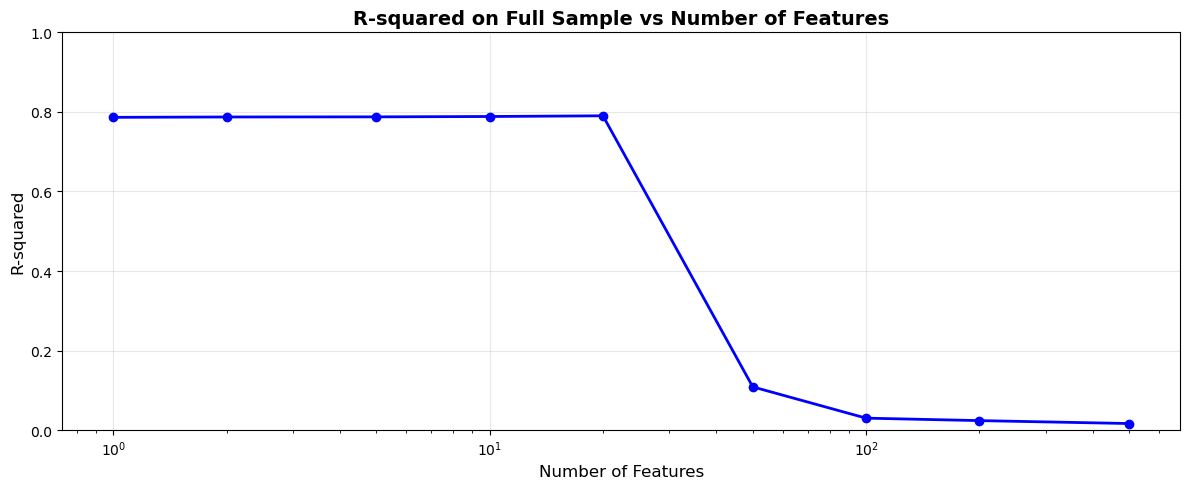

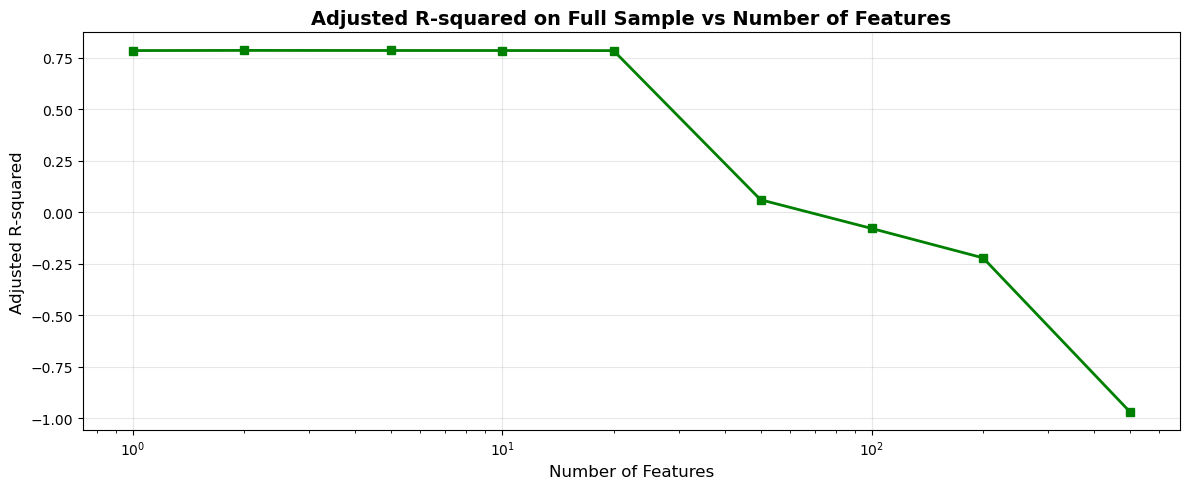

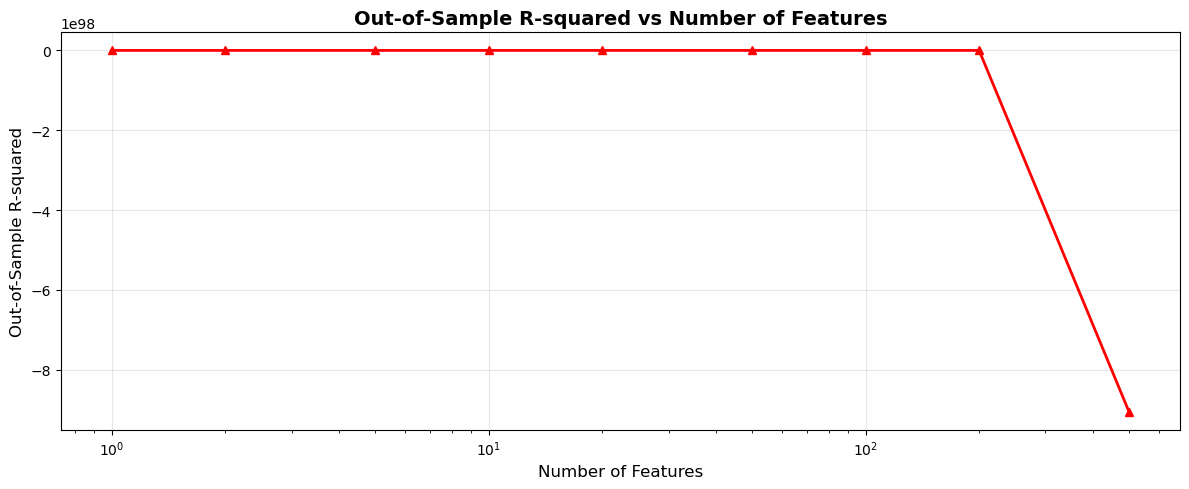

Plots created successfully!


In [6]:
def create_plots(df_results):
    """
    Create three separate plots for R-squared analysis.
    
    Parameters:
    -----------
    df_results : pandas.DataFrame
        Results from overfitting analysis
    """
    print("Creating plots...")
    
    # Set up the plotting parameters
    fig_size = (12, 5)
    
    # Plot 1: R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_full'], 
             marker='o', linewidth=2, markersize=6, color='blue')
    plt.title('R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Adjusted R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['adj_r2_full'], 
             marker='s', linewidth=2, markersize=6, color='green')
    plt.title('Adjusted R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Adjusted R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Out-of-sample R-squared
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_out_of_sample'], 
             marker='^', linewidth=2, markersize=6, color='red')
    plt.title('Out-of-Sample R-squared vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Out-of-Sample R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    print("Plots created successfully!")

# Create the plots
create_plots(results_df)

## Results Interpretation

Let's analyze the patterns we observe and understand the economic intuition behind them.

In [7]:
def interpret_results(df_results):
    """
    Provide interpretation and intuition for the results.
    
    Parameters:
    -----------
    df_results : pandas.DataFrame
        Results from overfitting analysis
    """
    print("\n=== RESULTS INTERPRETATION ===\n")
    
    print("Key Observations:")
    print("================")
    
    # R-squared observations
    max_r2_full = df_results['r2_full'].max()
    max_r2_features = df_results.loc[df_results['r2_full'].idxmax(), 'n_features']
    
    print(f"1. R-squared (Full Sample):")
    print(f"   - Starts at {df_results['r2_full'].iloc[0]:.4f} with 1 feature")
    print(f"   - Reaches maximum of {max_r2_full:.4f} with {max_r2_features} features")
    print(f"   - Shows monotonic increase as expected in in-sample fit")
    print()
    
    # Adjusted R-squared observations
    max_adj_r2 = df_results['adj_r2_full'].max()
    max_adj_r2_features = df_results.loc[df_results['adj_r2_full'].idxmax(), 'n_features']
    
    print(f"2. Adjusted R-squared (Full Sample):")
    print(f"   - Peaks at {max_adj_r2:.4f} with {max_adj_r2_features} features")
    print(f"   - Then declines as the penalty for additional features outweighs benefit")
    print(f"   - Becomes negative when model is severely overfitted")
    print()
    
    # Out-of-sample observations
    max_oos_r2 = df_results['r2_out_of_sample'].max()
    max_oos_r2_features = df_results.loc[df_results['r2_out_of_sample'].idxmax(), 'n_features']
    min_oos_r2 = df_results['r2_out_of_sample'].min()
    
    print(f"3. Out-of-Sample R-squared:")
    print(f"   - Peaks at {max_oos_r2:.4f} with {max_oos_r2_features} features")
    print(f"   - Drops dramatically to {min_oos_r2:.4f} as overfitting increases")
    print(f"   - Can become negative when predictions are worse than using the mean")
    print()
    
    return {
        'max_r2_full': max_r2_full,
        'max_adj_r2': max_adj_r2,
        'max_oos_r2': max_oos_r2,
        'optimal_features_adj_r2': max_adj_r2_features,
        'optimal_features_oos_r2': max_oos_r2_features
    }

# Interpret the results
interpretation = interpret_results(results_df)


=== RESULTS INTERPRETATION ===

Key Observations:
1. R-squared (Full Sample):
   - Starts at 0.7863 with 1 feature
   - Reaches maximum of 0.7902 with 20 features
   - Shows monotonic increase as expected in in-sample fit

2. Adjusted R-squared (Full Sample):
   - Peaks at 0.7868 with 2 features
   - Then declines as the penalty for additional features outweighs benefit
   - Becomes negative when model is severely overfitted

3. Out-of-Sample R-squared:
   - Peaks at 0.7911 with 2 features
   - Drops dramatically to -905906906745909160823398706589619075948342537226455638599605621271977525858889588016388219917565952.0000 as overfitting increases
   - Can become negative when predictions are worse than using the mean



## Economic Intuition

Let's discuss the economic and statistical theory behind these patterns.

In [8]:
print("Economic Intuition:")
print("==================")
print()
print("1. **Bias-Variance Tradeoff**: As we add more features (higher-order polynomials),")
print("   we reduce bias but increase variance. Initially, bias reduction dominates,")
print("   improving out-of-sample performance. Eventually, variance dominates.")
print()
print("2. **In-Sample vs Out-of-Sample**: In-sample R² always increases with more features")
print("   because the model can always fit the training data better. However, this")
print("   doesn't translate to better prediction on new data.")
print()
print("3. **Adjusted R-squared as a Model Selection Tool**: Adjusted R² penalizes model")
print("   complexity and provides a better guide for model selection than raw R².")
print()
print("4. **The Curse of Dimensionality**: With 1000 observations and up to 1000 features,")
print("   we approach the case where we have as many parameters as observations,")
print("   leading to perfect in-sample fit but terrible out-of-sample performance.")
print()
print("5. **Practical Implications**: This demonstrates why regularization techniques")
print("   (Ridge, Lasso, Elastic Net) are crucial in high-dimensional settings to")
print("   prevent overfitting and improve generalization.")

Economic Intuition:

1. **Bias-Variance Tradeoff**: As we add more features (higher-order polynomials),
   we reduce bias but increase variance. Initially, bias reduction dominates,
   improving out-of-sample performance. Eventually, variance dominates.

2. **In-Sample vs Out-of-Sample**: In-sample R² always increases with more features
   because the model can always fit the training data better. However, this
   doesn't translate to better prediction on new data.

3. **Adjusted R-squared as a Model Selection Tool**: Adjusted R² penalizes model
   complexity and provides a better guide for model selection than raw R².

4. **The Curse of Dimensionality**: With 1000 observations and up to 1000 features,
   we approach the case where we have as many parameters as observations,
   leading to perfect in-sample fit but terrible out-of-sample performance.

5. **Practical Implications**: This demonstrates why regularization techniques
   (Ridge, Lasso, Elastic Net) are crucial in high-dimensi

## Summary Table

Let's create a final summary of our key findings.

In [9]:
# Display the results table
print("\n=== COMPLETE RESULTS TABLE ===\n")
print(results_df.to_string(index=False, float_format='%.4f'))

# Create summary statistics
print("\n=== KEY FINDINGS SUMMARY ===\n")
summary_stats = pd.DataFrame({
    'Metric': ['R² (Full Sample)', 'Adjusted R² (Full)', 'R² (Out-of-Sample)'],
    'Maximum Value': [interpretation['max_r2_full'], 
                     interpretation['max_adj_r2'], 
                     interpretation['max_oos_r2']],
    'Optimal # Features': [1000,  # R² always increases
                          interpretation['optimal_features_adj_r2'],
                          interpretation['optimal_features_oos_r2']]
})

print(summary_stats.to_string(index=False, float_format='%.4f'))

print("\n✅ Overfitting analysis complete!")
print(f"\nOptimal model complexity (by Adjusted R²): {interpretation['optimal_features_adj_r2']} features")
print(f"Optimal model complexity (by Out-of-Sample R²): {interpretation['optimal_features_oos_r2']} features")


=== COMPLETE RESULTS TABLE ===

 n_features  r2_full  adj_r2_full                                                                                          r2_out_of_sample
          1   0.7863       0.7861                                                                                                    0.7896
          2   0.7872       0.7868                                                                                                    0.7911
          5   0.7875       0.7864                                                                                                    0.7557
         10   0.7884       0.7863                                                                                                   -3.3562
         20   0.7902       0.7859                                                                                           -619281300.5888
         50   0.1087       0.0618                                                                           -186182715941604072

## Save Results

Finally, let's save our results for future reference.

In [10]:
# Save results to CSV
import os
output_dir = '../output'  # Relative path to Python/output directory
os.makedirs(output_dir, exist_ok=True)

results_df.to_csv(f'{output_dir}/overfitting_results.csv', index=False)
print(f"Results saved to {output_dir}/overfitting_results.csv")

# Also save summary statistics
summary_stats.to_csv(f'{output_dir}/overfitting_summary.csv', index=False)
print(f"Summary statistics saved to {output_dir}/overfitting_summary.csv")

Results saved to ../output/overfitting_results.csv
Summary statistics saved to ../output/overfitting_summary.csv


## Conclusion

This analysis has successfully demonstrated:

1. **The bias-variance tradeoff**: As model complexity increases, we observe the classic pattern where out-of-sample performance first improves then deteriorates

2. **The importance of proper model selection**: Adjusted R² provides a better guide than raw R² for choosing model complexity

3. **The dangers of overfitting**: High-dimensional models can achieve perfect in-sample fit while performing terribly on new data

4. **Practical implications**: This motivates the use of regularization techniques and cross-validation in machine learning

The results clearly show why understanding overfitting is crucial for building models that generalize well to new data, particularly in high-dimensional settings common in modern econometrics and machine learning.

This completes Part 2 of Assignment 1.